#TODO:
- Implement Maxime's solution
- Remove trials when the animal is not engaged

# This notebook analyses data from Bpod.

## Tested on output of protocol 'Two_Alternative_Choice'

***
** Import stuff and select animal **
***

In [1]:
%load_ext autoreload
%autoreload 2
from utils import custom_functions, plot_utils, Lapse_model
import os
import sys
sys.path.append("../") # go to parent 
import Bpod_OE_Francesca.utils.load_nested_structs as load_ns
from OpenEphys_Analysis.utils.custom_functions import update_progress
import glob
import ntpath
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
import math
import seaborn as sns
import pandas as pd
import warnings
from itertools import chain

warnings.filterwarnings('ignore')

In [2]:
# Select animal to analyze
AnimalID = 'N06'
# Task
BpodProtocol = '/Two_Alternative_Choice/'
# Behavioural data
GeneralDirectory = '/mnt/c/Users/herny/Desktop/SWC/Data/Behavioural_Data/Bpod_data/'

# Create out directory if it does not exist
outputDir = GeneralDirectory + AnimalID + BpodProtocol + 'Data_Analysis/'
if not os.path.isdir(outputDir):
    os.mkdir(outputDir)

***
** Read data, clean it, and plot basic stuff **

In [3]:
def ReadAnimalData(GeneralDirectory, AnimalID, BpodProtocol, printout = True):
    # Reads all data from one animal and one protocol
    
    # Initialize return lists
    ExperimentFiles = [] # to store experiment names
    ExperimentData = [] # to store the dictionaries
    ntrialsDistribution = [] # to visualize the distribution of the number of trials
    Protocols = [] # store the protocols
    Stimulations = [] # store the stimulated protocols
    Muscimol = [] # store information about the muscimol
    counter = 0
    filelist = glob.glob(GeneralDirectory+AnimalID + BpodProtocol +'Session Data/*.mat')
    filelist.sort()
    for file in filelist:
        # Read data
        data = load_ns.loadmat(file)
        
        # if that session is empty skip it:
        if not 'nTrials' in data['SessionData']:
            continue
        
        ntrials = data['SessionData']['nTrials'] # this sometimes fails if the session is empty

        ExperimentFiles.append(file)
        # Parse the settings of the trials
        trial_settings = data['SessionData']['TrialSettings']
        try:
            for trial_num, trial in enumerate(trial_settings):
                trial_settings[trial_num] = load_ns._todict(trial)
            data['SessionData']['TrialSettings'] = trial_settings
        except:
            data['SessionData']['TrialSettings'] = np.nan

        # Get info for the settings from the first trial
        try:
            protocol = trial_settings[0]['GUIMeta']['TrainingLevel']['String'][
                trial_settings[0]['GUI']['TrainingLevel'] - 1]
        except:
            protocol = 'Unknown'

        try:
            stimulation = trial_settings[0]['GUIMeta']['OptoStim']['String'][
                trial_settings[0]['GUI']['OptoStim'] - 1]
        except:
            stimulation = 'unknown'
        
        try:
            muscimol = trial_settings[0]['GUIMeta']['Muscimol']['String'][
                trial_settings[0]['GUI']['Muscimol'] - 1]
        except:
            muscimol = 'unknown'
        
        if printout:
            print('{}: {}, {} trials on {}, stim {}, muscimol {}'.format(\
                    counter, ntpath.basename(file), ntrials, protocol, stimulation, muscimol))
        
        ntrialsDistribution.append(ntrials)
        Protocols.append(protocol)
        Stimulations.append(stimulation)
        Muscimol.append(muscimol)

        # as RawEvents.Trial is a cell array of structs in MATLAB, we have to loop through the array and convert the structs to dicts
        trial_raw_events = data['SessionData']['RawEvents']['Trial']
        try:
            for trial_num, trial in enumerate(trial_raw_events):
                trial_raw_events[trial_num] = load_ns._todict(trial)
            data['SessionData']['RawEvents']['Trial'] = trial_raw_events
        except:
            data['SessionData']['RawEvents']['Trial'] = np.nan
        

        # Save the data in a list
        ExperimentData.append(data)
        counter+=1
        
    return ExperimentFiles, ExperimentData, ntrialsDistribution, Protocols, Stimulations, Muscimol

In [4]:
# Read data
ExperimentFiles, ExperimentData, ntrialsDistribution, Protocols, Stimulations, Muscimol =\
ReadAnimalData(GeneralDirectory, AnimalID, BpodProtocol, printout = True)

0: N06_Two_Alternative_Choice_20190506_113757.mat, 154 trials on Habituation, stim NoStimulation, muscimol unknown
1: N06_Two_Alternative_Choice_20190509_112933.mat, 63 trials on Visual, stim NoStimulation, muscimol unknown
2: N06_Two_Alternative_Choice_20190514_125730.mat, 99 trials on Visual, stim NoStimulation, muscimol unknown
3: N06_Two_Alternative_Choice_20190514_131922.mat, 151 trials on Visual, stim NoStimulation, muscimol unknown
4: N06_Two_Alternative_Choice_20190515_122136.mat, 341 trials on Visual, stim NoStimulation, muscimol unknown
5: N06_Two_Alternative_Choice_20190516_115432.mat, 245 trials on Visual, stim NoStimulation, muscimol unknown
6: N06_Two_Alternative_Choice_20190517_103818.mat, 291 trials on Visual, stim NoStimulation, muscimol unknown
7: N06_Two_Alternative_Choice_20190518_123000.mat, 214 trials on Visual, stim NoStimulation, muscimol unknown
8: N06_Two_Alternative_Choice_20190520_143022.mat, 226 trials on Visual, stim NoStimulation, muscimol unknown
9: N06_

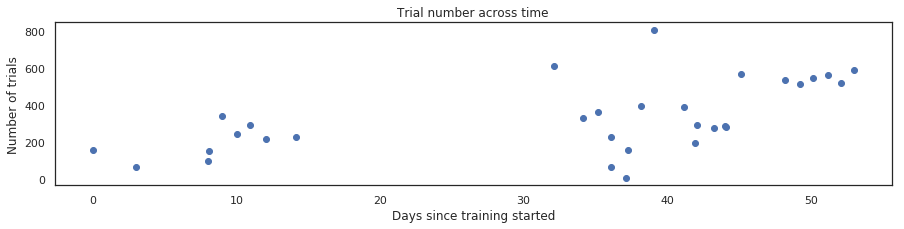

In [116]:
# get the date and time from the files
ExperimentTimes = custom_functions.ParseForTimes(ExperimentFiles)
ExperimentDates = custom_functions.ParseForDates(ExperimentFiles)
TimeDifferences = custom_functions.timeDifferences(ExperimentTimes)

# Transform to e.g. Feb20
ExperimentDatesPretty = custom_functions.MakeDatesPretty(ExperimentTimes)

# plot number of trials  
fig, ax = plt.subplots(figsize=(15,3))
plt.plot(TimeDifferences, ntrialsDistribution, 'o')
plt.title('Trial number across time')
plt.ylabel('Number of trials')
plt.xlabel('Days since training started')
plt.show()

In [117]:
# Clean data
# Remove those experiments fow which a proper time has not been found (old ones that are missing a lot of variables)
# Or those with low number of trials
minNoOfTr = 30
idxToRemove = custom_functions.identifyIdx(ExperimentTimes, ntrialsDistribution, minNoOfTr)

for idx in idxToRemove:
    print('deleting data for {} with {} trials'.format(ntpath.basename(ExperimentFiles[idx]), ntrialsDistribution[idx]))
    ExperimentData.pop(idx)
    ExperimentDates.pop(idx)
    ExperimentDatesPretty.pop(idx)
    ExperimentFiles.pop(idx)
    ExperimentTimes.pop(idx)
    ntrialsDistribution.pop(idx)
    Protocols.pop(idx)
    Stimulations.pop(idx)
    Muscimol.pop(idx)

deleting data for N06_Two_Alternative_Choice_20190613_152140.mat with 5 trials


In [118]:
# get all data into a dataframe
DataFrames = [custom_functions.SessionDataToDataFrame(AnimalID, ExperimentDatesPretty[i], exp['SessionData'])
              for i,exp in enumerate(ExperimentData)]

AnimalDF = pd.concat(DataFrames, ignore_index=True)

In [119]:
'''
### OPTIONAL ###
# Change stuff for some sessions if they are wrong
AnimalDF.Muscimol.iloc[AnimalDF[AnimalDF['SessionTime']=='Jun10 15:12'].index] = 'No'
'''

"\n### OPTIONAL ###\n# Change stuff for some sessions if they are wrong\nAnimalDF.Muscimol.iloc[AnimalDF[AnimalDF['SessionTime']=='Jun10 15:12'].index] = 'No'\n"


***

**Remove experiments that are not good**

***

Progress: [####################] 100.0%


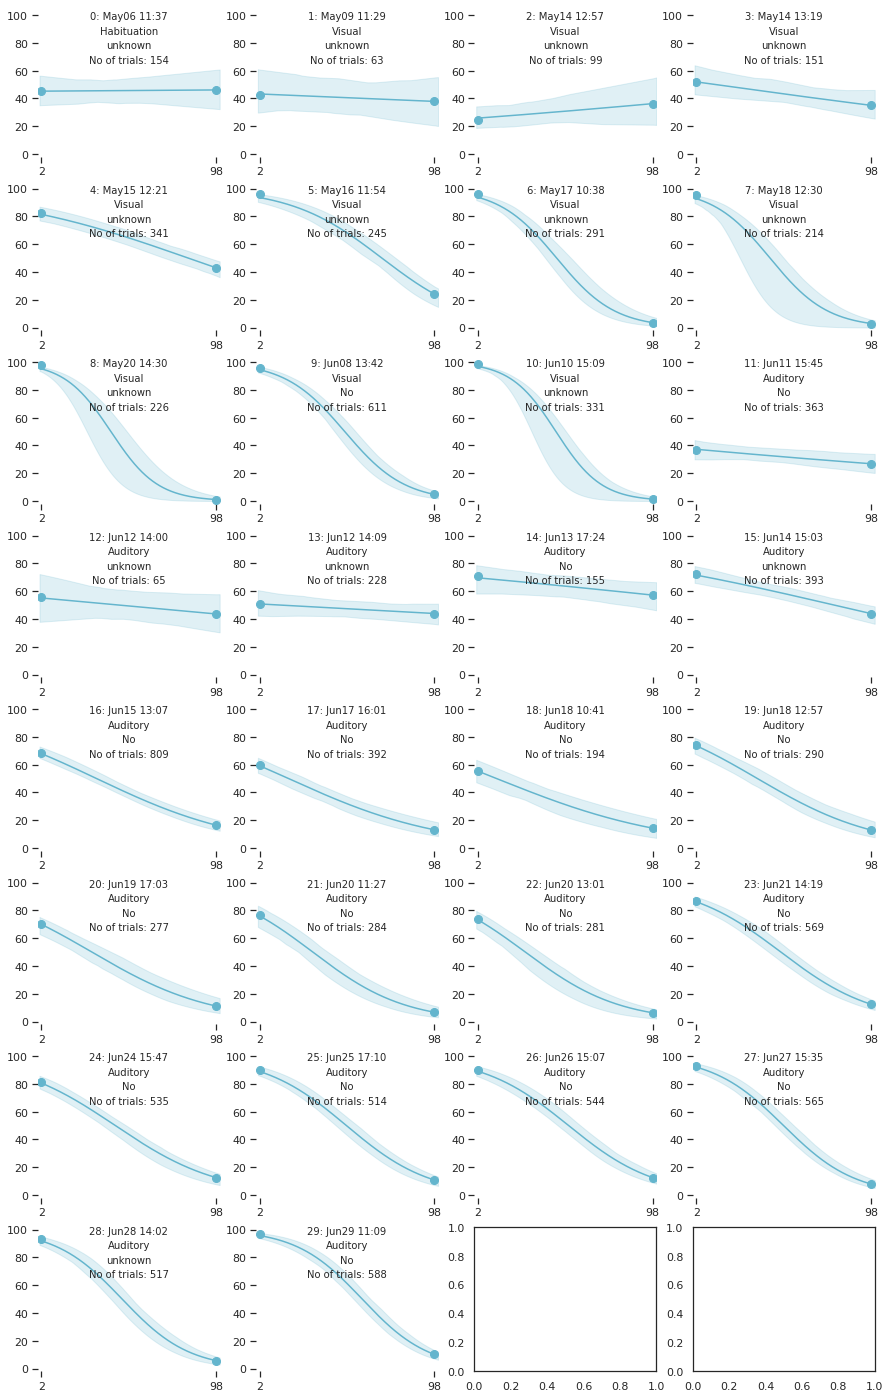

In [120]:
# Make a plot with the performance for all sessions MAKE THIS PRETTIER, CLEAN THIS AS BELOW

fig, axs = plt.subplots(math.ceil(len(pd.unique(AnimalDF['SessionTime']))/4), 4, figsize=(15, 25), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .2, wspace=.2)
axs = axs.ravel()


# process data from all experiments
for counter, session in enumerate(pd.unique(AnimalDF['SessionTime'])):    
    predictDif, Normal_PsyPer, Normal_fakePredictions, Normal_predictPer, _ = \
    custom_functions.PP_ProcessExperiment(AnimalDF[(AnimalDF['SessionTime']==session) & (AnimalDF['OptoStim']==0)], 100)
    
    _, Opto_PsyPer, Opto_fakePredictions, Opto_predictPer, _ = \
    custom_functions.PP_ProcessExperiment(AnimalDF[(AnimalDF['SessionTime']==session) & (AnimalDF['OptoStim']==1)], 100)
    
    if Normal_PsyPer:
        plot_utils.PlotPsychPerformance(dataDif = Normal_PsyPer['Difficulty'], dataPerf = Normal_PsyPer['Performance'],
                         predictDif = predictDif, ax = axs[counter], fakePred = Normal_fakePredictions,
                         realPred = Normal_predictPer, color = 'c', label = 'normal')

    if Opto_PsyPer:
        plot_utils.PlotPsychPerformance(dataDif = Opto_PsyPer['Difficulty'], dataPerf = Opto_PsyPer['Performance'],
                             predictDif = predictDif, ax = axs[counter], fakePred = Opto_fakePredictions,
                             realPred = Opto_predictPer, color = 'm', label = 'opto')
        
    axs[counter].get_legend().remove()
    axs[counter].text(.5,.95, str(counter) + ': ' + str(session), \
                      horizontalalignment='center', transform=axs[counter].transAxes)
    axs[counter].text(.5,.85, Protocols[counter] , \
                      horizontalalignment='center', transform=axs[counter].transAxes)
    axs[counter].text(.5,.75, Muscimol[counter] , \
                      horizontalalignment='center', transform=axs[counter].transAxes)
    axs[counter].text(.5,.65, 'No of trials: ' + str(ntrialsDistribution[counter]) , \
                      horizontalalignment='center', transform=axs[counter].transAxes)
    axs[counter].set_ylabel('')
    axs[counter].set_xlabel('')

    update_progress(counter / len(pd.unique(AnimalDF['SessionTime'])))
    
update_progress(1)
plt.savefig(outputDir + AnimalID + '_psychometricPerformanceAllSessions.pdf', transparent=True, bbox_inches='tight')

plt.show(fig)

In [70]:
# Select indexes to remove and remove them
expToRemove = []

IDsToRemove = [] # do not write here
for counter, session in enumerate(pd.unique(AnimalDF['SessionTime'])):
    if counter in expToRemove:
        print(session + ' Removed')
        IDsToRemove.append(session)

AnimalDF = AnimalDF.loc[~AnimalDF['SessionTime'].isin(IDsToRemove)]

Jun14 14:00 Removed


In [121]:
# save the dataframe
AnimalDF.to_pickle(outputDir + AnimalID + '_dataframe.pkl')

***
**Make a summary plot of the sesssions and performances**

***

In [209]:
# read data like this:
AnimalDF = pd.read_pickle(outputDir + AnimalID + '_dataframe.pkl')

In [15]:
# Initialize lists to save important data
DifficultyValues = []
PerformanceValues = []

# process data from all experiments
for counter, session in enumerate(pd.unique(AnimalDF['SessionTime'])):    
    predictDif, PsyPer,fakePredictions, predictPer, _ = \
    custom_functions.PP_ProcessExperiment(AnimalDF[AnimalDF['SessionTime']==session])

    #append to lists, only the normal trials
    DifficultyValues.append(PsyPer['Difficulty'])
    PerformanceValues.append(PsyPer['Performance'])

    update_progress(counter / len(pd.unique(AnimalDF['SessionTime'])))
    
update_progress(1)


# calculate difficulty levels
difLevels = np.unique(np.concatenate(DifficultyValues).ravel())
# Initialize the matrix
matToPlot = np.full([len(difLevels), len(DifficultyValues)], np.nan)
# Loop to fill it
for i, dif in enumerate(difLevels):
    for j, per in enumerate(PerformanceValues):
        if dif in DifficultyValues[j]:
            idxOfDif = np.where(DifficultyValues[j]==dif)[0][0]
            matToPlot[i,j] = per[idxOfDif]

# Transform to dataframe
dfToPlot = pd.DataFrame(matToPlot)
dfToPlot = dfToPlot.set_index(difLevels) # set row names
dfToPlot.columns = pd.unique(AnimalDF['SessionTime']) # set col names 

Progress: [####################] 100.0%


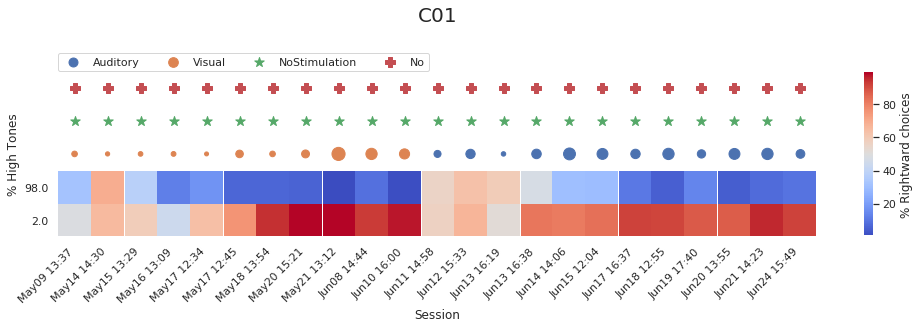

In [16]:
# plot it
sns.set(style="white")
fig, ax = plt.subplots(figsize=(17,5))
sns.heatmap(dfToPlot, linewidth=0.001, square=True, cmap="coolwarm",
            cbar_kws={"shrink": 0.6, 'label': '% Rightward choices'})
# TODO: check that the size is proportional (area vs radius)
# recalculate the number of trials as some might get grouped if they are on the same day. Do all below with the dataframe
Protocols = [pd.unique(AnimalDF[AnimalDF['SessionTime']==session]['Protocol'])[0] \
             for session in pd.unique(AnimalDF['SessionTime'])]
ntrialsDistribution = [len(AnimalDF[AnimalDF['SessionTime']==session]) for session in pd.unique(AnimalDF['SessionTime'])]
Stimulations = [pd.unique(AnimalDF[AnimalDF['SessionTime']==session]['Stimulation'])[0] \
             for session in pd.unique(AnimalDF['SessionTime'])]
Muscimol = [pd.unique(AnimalDF[AnimalDF['SessionTime']==session]['Muscimol'])[0] \
             for session in pd.unique(AnimalDF['SessionTime'])]

for pr_counter, prot in enumerate(np.unique(Protocols)):
    protIdx = [i for i, x in enumerate(Protocols) if x == prot]
    ax.scatter([x + 0.5 for x in protIdx], np.repeat(len(difLevels)+0.5, len(protIdx)), marker='o',
               s=[ntrialsDistribution[x]/5 for x in protIdx], label = prot) 
# label the opto sessions
for st_counter, stim in enumerate(np.unique(Stimulations)):
    stimIdx = [i for i, x in enumerate(Stimulations) if x == stim]
    ax.scatter([x + 0.5 for x in stimIdx], np.repeat(len(difLevels)+1.5, len(stimIdx)), marker='*', s=100, label = stim)
# label the muscimol sessions
for mus_counter, mus in enumerate(np.unique(Muscimol)):
    musIdx = [i for i, x in enumerate(Muscimol) if x == mus]
    ax.scatter([x + 0.5 for x in musIdx], np.repeat(len(difLevels)+2.5, len(musIdx)), marker='P', s=100, label = mus)
    
ax.legend(loc=(0,1), borderaxespad=0., ncol = 5, frameon=True)
ax.set_ylim([0, len(difLevels)+3])
plt.ylabel('% High Tones')
plt.xlabel('Session')
plt.yticks(rotation=0)
plt.xticks(horizontalalignment="right", rotation=45)
plt.title(AnimalID + '\n\n', fontsize=20, fontweight=0)
plt.savefig(outputDir + AnimalID + '_psychometricPerformanceAllSessionsHeatmap.pdf', transparent=True,
            dpi = 500, bbox_inches='tight')
plt.show(fig)

***
**Plot the evolution of the cumulative performance**
***

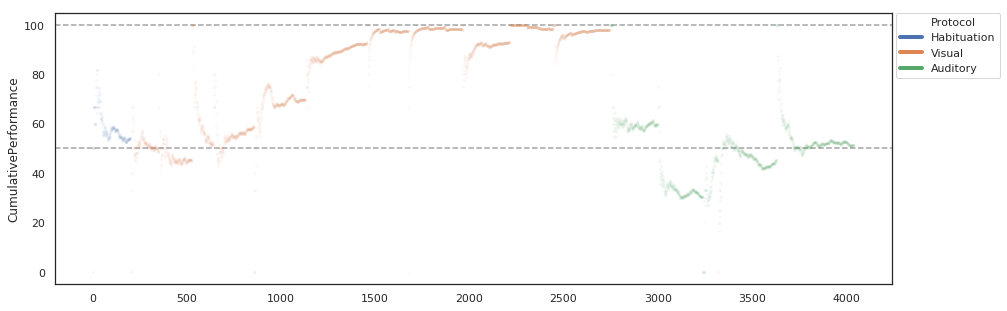

In [205]:
# TODO: include only the easy trials
# TODO: add lines to illustrate change of session
# TODO: label the sessions as above
fig, ax = plt.subplots(figsize=(15,5))
ax.axhline(50, ls='--', alpha=0.4, color='k')
ax.axhline(100, ls='--', alpha=0.4, color='k')
sns.lineplot(x = AnimalDF.index, y = 'CumulativePerformance', data=AnimalDF, hue = 'Protocol',
             marker=".", alpha = 0.05, markeredgewidth=0, linewidth=0)
    
lgd = plt.legend(bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.)
for l in lgd.get_lines():
    l.set_alpha(1)
    l.set_linewidth(4)

plt.savefig(outputDir + AnimalID + '_CumulativePerformance.pdf',
            transparent=True, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

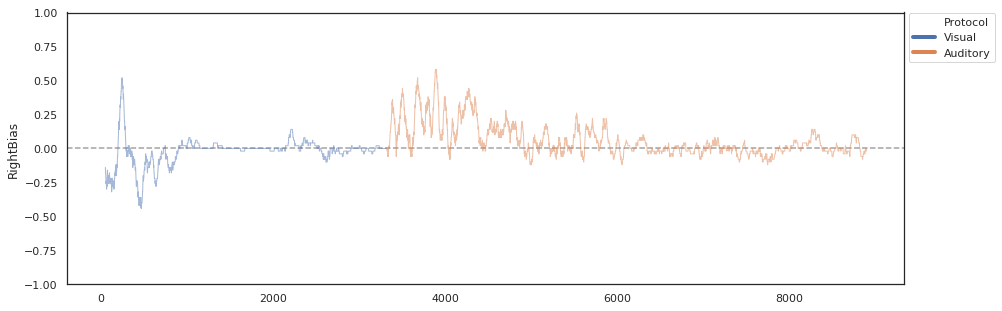

In [17]:
# plot the bias of the mouse over the sessions
AnimalDF['RightBias'] = custom_functions.CalculateRBiasWindow(np.array(AnimalDF['FirstPoke']),\
                                                              np.array(AnimalDF['FirstPokeCorrect']), 50)

fig, ax = plt.subplots(figsize=(15,5))
ax.axhline(0, ls='--', alpha=0.4, color='k')
sns.lineplot(x=AnimalDF.index, y='RightBias', data=AnimalDF, hue='Protocol',
             alpha=0.5, markeredgewidth=0, linewidth=1)
ax.set(ylim=(-1,1))  
lgd = plt.legend(bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.)
for l in lgd.get_lines():
    l.set_alpha(1)
    l.set_linewidth(4)

plt.savefig(outputDir + AnimalID + '_RightBias.pdf',
            transparent=True, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

***
**Plot percentage correct by session, based on whether the mouse stays on the same port or switches**
***

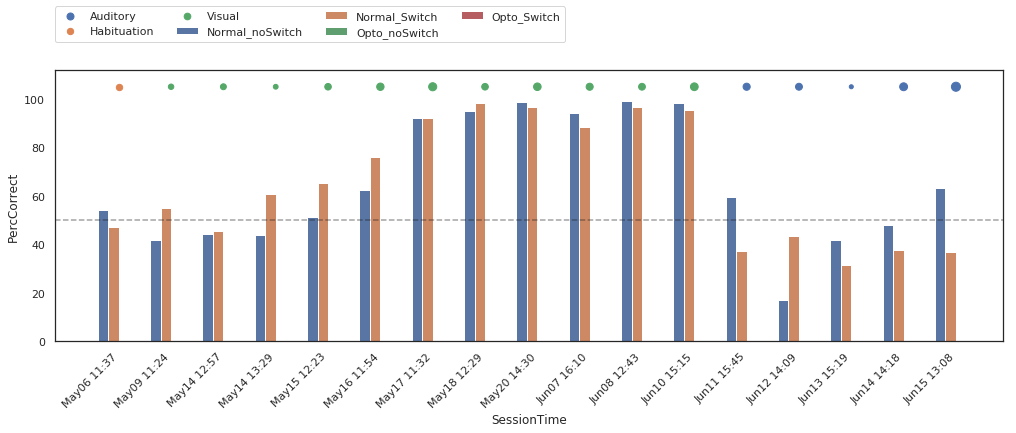

In [207]:
# Separate between trials that are ocurring in a row and those that the animal has to switch (repetitive vs new side)
dfForBP = custom_functions.AnalyzeSwitchTrials(AnimalDF)

fig, ax = plt.subplots(figsize=(17,5))
ax.axhline(50, ls='--', alpha=0.4, color='k')
sns.barplot(x='SessionTime', y='PercCorrect', hue='Condition', data=dfForBP)
# label the type of trials
for pr_counter, prot in enumerate(np.unique(Protocols)):
    protIdx = [i for i, x in enumerate(Protocols) if x == prot]
    ax.scatter([x for x in protIdx], np.repeat(105, len(protIdx)), marker='o',
               s=[ntrialsDistribution[x]/5 for x in protIdx], label = prot) 
lgd = plt.legend(loc=(0,1.1), borderaxespad=0., ncol = 4, frameon=True)
plt.xticks(horizontalalignment="right", rotation=45)
for l in lgd.get_lines():
    l.set_alpha(1)
    l.set_linewidth(1)
plt.savefig(outputDir + AnimalID + '_PercCorrectBySession.pdf',
            transparent=True, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

***
**Group sessions by type, by condition, or explore a single session**
***

In [189]:
# Group sessions by type
protToGroup = 'Aud_Psycho'
stimToGroup = 'Right'
pulledData = AnimalDF[(AnimalDF['Protocol']==protToGroup) & (AnimalDF['Stimulation']==stimToGroup)]

PlotsTitle = protToGroup + '_' + stimToGroup

# provide an option to select by session TODO!

In [219]:
# Select muscimol sessions and control sessions to compare to
Session_types = ['AUD1-bilat', 'AUD1-bilat-Control']
protToGroup = 'Aud_Psycho'
pulledData = AnimalDF[(AnimalDF['Protocol']==protToGroup) & (AnimalDF['Muscimol'].isin(Session_types))]

PlotsTitle = protToGroup + '_' + ' - '.join(Session_types)

In [70]:
# Select a single session
SelectedSession = 'May21 15:12'
pulledData = AnimalDF[AnimalDF['SessionTime']==SelectedSession]
PlotsTitle = SelectedSession

In [216]:
# Select multiple sessions
# For Os03 SelectedSessions = ['Apr10 15:22', 'Apr11 15:09', 'Apr16 17:25', 'Apr20 10:51', 'May01 13:11', 'May07 16:22', 'May17 13:58']
#SelectedSessions = ['Apr15 17:08', 'Apr18 13:24', 'Apr30 15:35', 'May04 13:38', 'May16 14:01']
SelectedSessions = ['Jun05 14:25', 'Jun06 15:16', 'Jun07 14:04', 'Jun10 15:12']
pulledData = AnimalDF[AnimalDF['SessionTime'].isin(SelectedSessions)]
PlotsTitle = ' - '.join(SelectedSessions)
# check that it worked
pd.unique(pulledData['SessionTime'])

array(['Jun05 14:25', 'Jun06 15:16', 'Jun07 14:04', 'Jun10 15:12'],
      dtype=object)

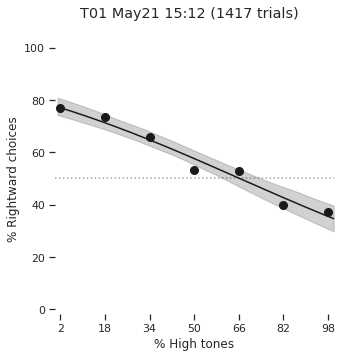

In [71]:
# simple plot
fig, axs = plt.subplots(figsize=(5, 5), facecolor='w', edgecolor='k')
axs.hlines(50, 0, 100, linestyles='dotted' , alpha=0.4)
predictDif, PsyPer, fakePredictions, predictPer, EB = \
custom_functions.PP_ProcessExperiment(pulledData, 100)
nTrials = max(pulledData['TrialIndex'])
if PsyPer:
    plot_utils.PlotPsychPerformance(dataDif = PsyPer['Difficulty'], dataPerf = PsyPer['Performance'],
                 predictDif = predictDif, ax = axs, fakePred = fakePredictions,
                 realPred = predictPer, color = 'k')
axs.get_legend().remove()
plt.suptitle(AnimalID + ' ' + PlotsTitle + ' (' + str(nTrials) + ' trials)')

plt.savefig(outputDir + AnimalID + '_' + PlotsTitle + '_psychometricPerformance.pdf',
            transparent=True, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show(fig)

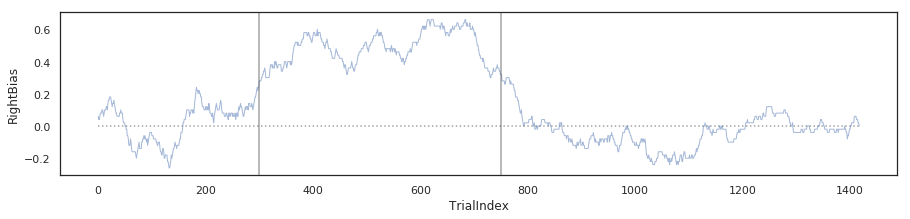

In [78]:
# Bias of the mouse
fig, axs = plt.subplots(figsize=(15, 3), facecolor='w', edgecolor='k')
axs.hlines(0, min(pulledData['TrialIndex']), max(pulledData['TrialIndex']), linestyles='dotted' , alpha=0.4)
sns.lineplot(x='TrialIndex', y='RightBias', data=pulledData,
             alpha=0.5, markeredgewidth=0, linewidth=1)

# Select break points
BreakPoints = [300, 750]
for bp in BreakPoints:
    axs.axvline(bp, color='k', alpha=0.4)
    
plt.savefig(outputDir + AnimalID + '_' + PlotsTitle + '_split_trial_bias.pdf',
            transparent=True, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()


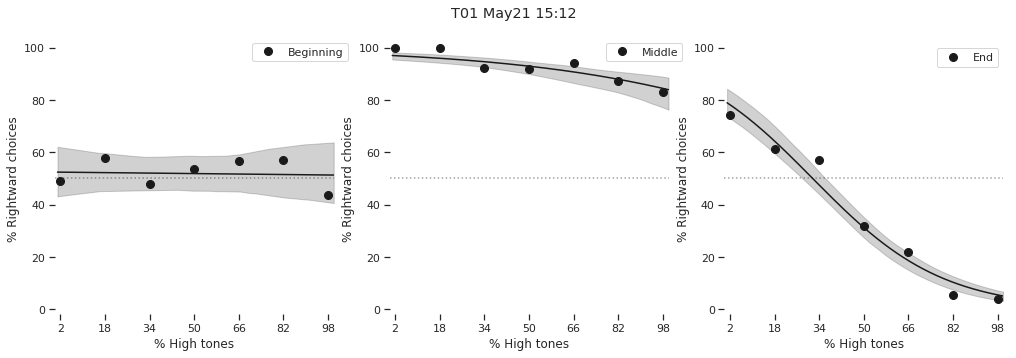

In [79]:
# Psych curves for those periods

# generate a list of the conditions, colors and labels
CondList = [(pulledData['TrialIndex'] < BreakPoints[0]),
            (pulledData['TrialIndex'] > BreakPoints[0]) & (pulledData['TrialIndex'] < BreakPoints[1]),
            (pulledData['TrialIndex'] > BreakPoints[1])]
ColorList = ['k', 'k', 'k']
LabelList = ['Beginning', 'Middle', 'End']
AxsOrder = [0,1,2]

# plot
fig, axs = plt.subplots(1,3,figsize=(17, 5), facecolor='w', edgecolor='k')
axs = axs.ravel()
for ax in axs:
    ax.hlines(50, 0, 100, linestyles='dotted' , alpha=0.4)
for i, condition in enumerate(CondList):
    predictDif, PsyPer, fakePredictions, predictPer, EB = \
    custom_functions.PP_ProcessExperiment(pulledData[condition], 100, error_bars='SessionTime')
    if PsyPer:
        plot_utils.PlotPsychPerformance(dataDif = PsyPer['Difficulty'], dataPerf = PsyPer['Performance'],
                     predictDif = predictDif, ax = axs[AxsOrder[i]], fakePred = fakePredictions,
                     realPred = predictPer, color = ColorList[i], label = LabelList[i], errorBars = EB)
lgd = plt.legend()
plt.suptitle(AnimalID + ' ' + PlotsTitle)

plt.savefig(outputDir + AnimalID + '_' + PlotsTitle + '_split_trial_psych.pdf',
            transparent=True, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show(fig)

No handles with labels found to put in legend.


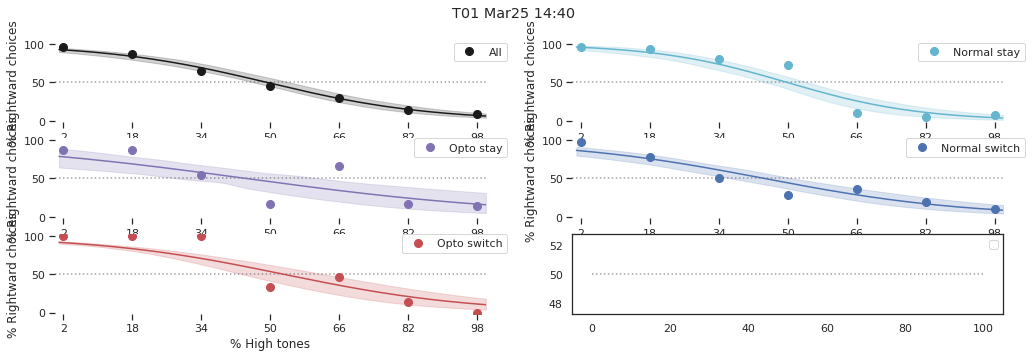

In [30]:
# plot basics about the mouse decision
# Plot differences if it the mouse has to switch, and if the previous trial was a success or not
PrevTrialSuccess = np.insert(np.array(pulledData['FirstPokeCorrect'][:-1]), 0, np.nan)

# generate a list of the conditions, colors and labels
CondList = [(pulledData['AnimalID']==AnimalID), # all data
            (PrevTrialSuccess==1) & (pulledData['SwitchSide']==0),
            (PrevTrialSuccess==0) & (pulledData['SwitchSide']==0),
            (PrevTrialSuccess==1) & (pulledData['SwitchSide']==1),
            (PrevTrialSuccess==0) & (pulledData['SwitchSide']==1)]
ColorList = ['k', 'c', 'm', 'b', 'r']
LabelList = ['All', 'Normal stay', 'Opto stay', 'Normal switch', 'Opto switch']
AxsOrder = [0,1,2,3,4]

# plot
fig, axs = plt.subplots(3,2,figsize=(17, 5), facecolor='w', edgecolor='k')
axs = axs.ravel()
for ax in axs:
    ax.hlines(50, 0, 100, linestyles='dotted' , alpha=0.4)
for i, condition in enumerate(CondList):
    predictDif, PsyPer, fakePredictions, predictPer, EB = \
    custom_functions.PP_ProcessExperiment(pulledData[condition], 100, error_bars='SessionTime')
    if PsyPer:
        plot_utils.PlotPsychPerformance(dataDif = PsyPer['Difficulty'], dataPerf = PsyPer['Performance'],
                     predictDif = predictDif, ax = axs[AxsOrder[i]], fakePred = fakePredictions,
                     realPred = predictPer, color = ColorList[i], label = LabelList[i], errorBars = EB)
lgd = plt.legend()
plt.suptitle(AnimalID + ' ' + PlotsTitle)

plt.savefig(outputDir + AnimalID + '_' + PlotsTitle + '_psychometricPerformance.pdf',
            transparent=True, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show(fig)

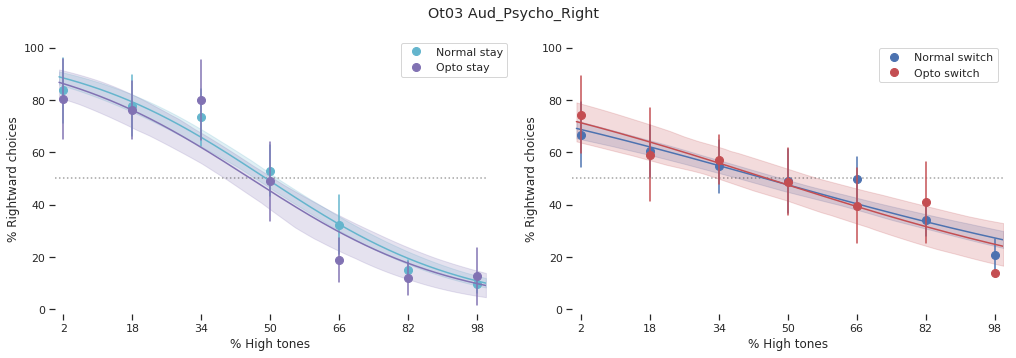

In [190]:
# plot differences between opto and normal trials if the mouse has to switch side or not
# generate a list of the conditions, colors and labels
CondList = [(pulledData['OptoStim']==0) & (pulledData['SwitchSide']==0),
            (pulledData['OptoStim']==1) & (pulledData['SwitchSide']==0),
            (pulledData['OptoStim']==0) & (pulledData['SwitchSide']==1),
            (pulledData['OptoStim']==1) & (pulledData['SwitchSide']==1)]
ColorList = ['c', 'm', 'b', 'r']
LabelList = ['Normal stay', 'Opto stay', 'Normal switch', 'Opto switch']
AxsOrder = [0,0,1,1]

# plot
fig, axs = plt.subplots(1,2,figsize=(17, 5), facecolor='w', edgecolor='k')
axs = axs.ravel()
for ax in axs:
    ax.hlines(50, 0, 100, linestyles='dotted' , alpha=0.4)
for i, condition in enumerate(CondList):
    predictDif, PsyPer, fakePredictions, predictPer, EB = \
    custom_functions.PP_ProcessExperiment(pulledData[condition], 100, error_bars='SessionTime')
    if PsyPer:
        plot_utils.PlotPsychPerformance(dataDif = PsyPer['Difficulty'], dataPerf = PsyPer['Performance'],
                     predictDif = predictDif, ax = axs[AxsOrder[i]], fakePred = fakePredictions,
                     realPred = predictPer, color = ColorList[i], label = LabelList[i], errorBars = EB)
lgd = plt.legend()
plt.suptitle(AnimalID + ' ' + PlotsTitle)

plt.savefig(outputDir + AnimalID + '_' + PlotsTitle + '_psychometricPerformance.pdf',
            transparent=True, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show(fig)

In [191]:
# Do the same as above but select only the first X stimulation trials per session
# Create a count for the stimulation trials
CumTrialsList = []
for Sid in pd.unique(pulledData['SessionTime']):
    CumTrialsList.append(np.cumsum(pulledData[pulledData['SessionTime']==Sid]['OptoStim']))
# flatten the list of lists
pulledData['OptoStimCumulative'] = np.array(list(chain(*[x for x in CumTrialsList])))

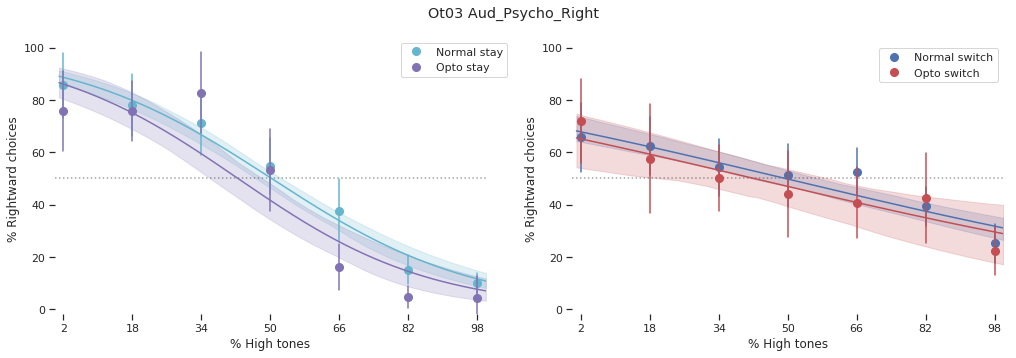

In [192]:
# plot
# Define the max number of stimulation trials
NST = 50
# generate a list of the conditions, colors and labels
CondList = [(pulledData['OptoStim']==0) & (pulledData['SwitchSide']==0) & (pulledData['OptoStimCumulative']<=NST),
            (pulledData['OptoStim']==1) & (pulledData['SwitchSide']==0) & (pulledData['OptoStimCumulative']<=NST),
            (pulledData['OptoStim']==0) & (pulledData['SwitchSide']==1) & (pulledData['OptoStimCumulative']<=NST),
            (pulledData['OptoStim']==1) & (pulledData['SwitchSide']==1) & (pulledData['OptoStimCumulative']<=NST)]
ColorList = ['c', 'm', 'b', 'r']
LabelList = ['Normal stay', 'Opto stay', 'Normal switch', 'Opto switch']
AxsOrder = [0,0,1,1]

# plot
fig, axs = plt.subplots(1,2,figsize=(17, 5), facecolor='w', edgecolor='k')
axs = axs.ravel()
for ax in axs:
    ax.hlines(50, 0, 100, linestyles='dotted' , alpha=0.4)
for i, condition in enumerate(CondList):
    predictDif, PsyPer, fakePredictions, predictPer, EB = \
    custom_functions.PP_ProcessExperiment(pulledData[condition], 100, error_bars='SessionTime')
    if PsyPer:
        plot_utils.PlotPsychPerformance(dataDif = PsyPer['Difficulty'], dataPerf = PsyPer['Performance'],
                     predictDif = predictDif, ax = axs[AxsOrder[i]], fakePred = fakePredictions,
                     realPred = predictPer, color = ColorList[i], label = LabelList[i], errorBars = EB)
lgd = plt.legend()
plt.suptitle(AnimalID + ' ' + PlotsTitle)

plt.savefig(outputDir + AnimalID + '_' + PlotsTitle + '_psychometricPerformance_NST.pdf',
            transparent=True, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show(fig)

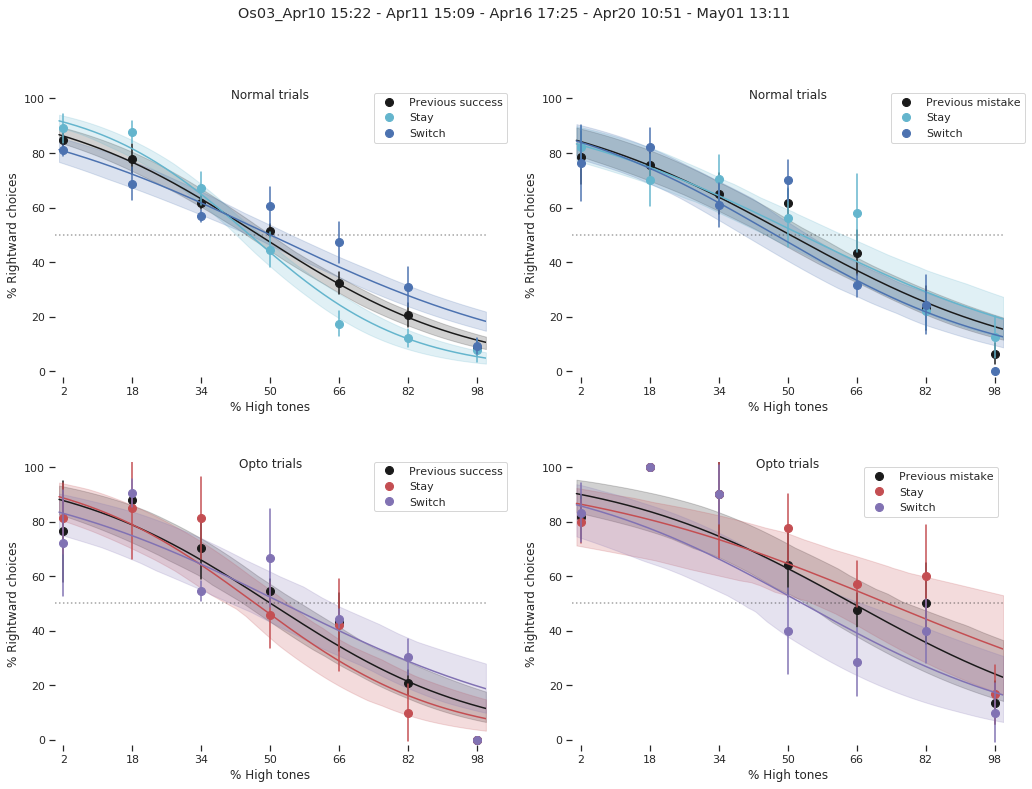

In [137]:
# Plot differences if it the mouse has to switch, and if the previous trial was a success or not
PrevTrialSuccess = np.insert(np.array(pulledData['FirstPokeCorrect'][:-1]), 0, np.nan)
# generate a list of the conditions, colors and labels
CondList = [(pulledData['OptoStim']==0) & (PrevTrialSuccess==1),
            (pulledData['OptoStim']==0) & (PrevTrialSuccess==1) & (pulledData['SwitchSide']==0),
            (pulledData['OptoStim']==0) & (PrevTrialSuccess==1) & (pulledData['SwitchSide']==1),
            (pulledData['OptoStim']==0) & (PrevTrialSuccess==0),
            (pulledData['OptoStim']==0) & (PrevTrialSuccess==0) & (pulledData['SwitchSide']==0),
            (pulledData['OptoStim']==0) & (PrevTrialSuccess==0) & (pulledData['SwitchSide']==1),
            (pulledData['OptoStim']==1) & (PrevTrialSuccess==1),
            (pulledData['OptoStim']==1) & (PrevTrialSuccess==1) & (pulledData['SwitchSide']==0),
            (pulledData['OptoStim']==1) & (PrevTrialSuccess==1) & (pulledData['SwitchSide']==1),
            (pulledData['OptoStim']==1) & (PrevTrialSuccess==0),
            (pulledData['OptoStim']==1) & (PrevTrialSuccess==0) & (pulledData['SwitchSide']==0),
            (pulledData['OptoStim']==1) & (PrevTrialSuccess==0) & (pulledData['SwitchSide']==1)]
ColorList = ['k', 'c', 'b', 'k', 'c', 'b','k', 'r', 'm', 'k', 'r', 'm']
LabelList = ['Previous success', 'Stay', 'Switch', 'Previous mistake', 'Stay', 'Switch',\
             'Previous success', 'Stay', 'Switch', 'Previous mistake', 'Stay', 'Switch']
AxsOrder = [0,0,0,1,1,1,2,2,2,3,3,3]
SubplotTitles = ['Normal trials', 'Normal trials', 'Opto trials', 'Opto trials',]
# plot
fig, axs = plt.subplots(2,2,figsize=(17, 12), facecolor='w', edgecolor='k')
axs = axs.ravel()
fig.subplots_adjust(hspace = 0.3)
for i, ax in enumerate(axs):
    ax.hlines(50, 0, 100, linestyles='dotted' , alpha=0.4)
    ax.text(50,100, SubplotTitles[i], horizontalalignment='center')
for i, condition in enumerate(CondList):
    predictDif, PsyPer, fakePredictions, predictPer, EB =\
    custom_functions.PP_ProcessExperiment(pulledData[condition], 100, error_bars='SessionTime')
    if PsyPer:
        plot_utils.PlotPsychPerformance(dataDif = PsyPer['Difficulty'], dataPerf = PsyPer['Performance'],
                     predictDif = predictDif, ax = axs[AxsOrder[i]], fakePred = fakePredictions,
                     realPred = predictPer, color = ColorList[i], label = LabelList[i], errorBars = EB)
lgd = plt.legend()
plt.suptitle(AnimalID + '_' + PlotsTitle)
plt.show(fig)

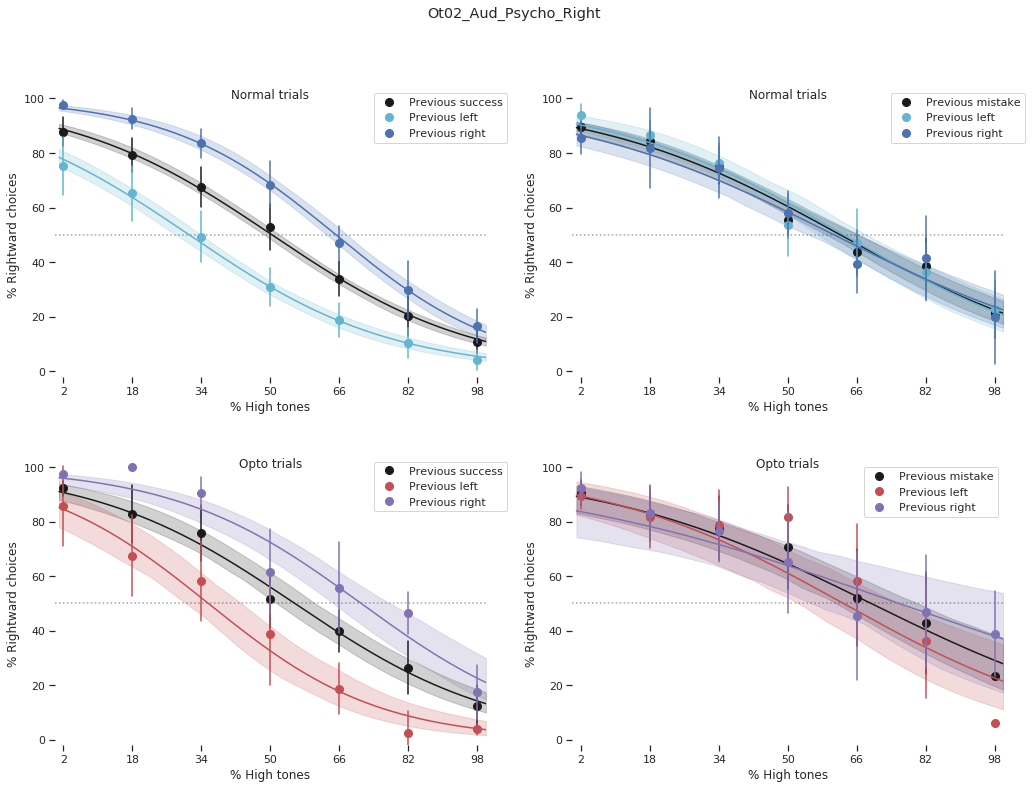

In [76]:
# Check responses to where the previous trial was (L or R) and previous success
PrevTrialSide = np.insert(np.array(pulledData['TrialSide'][:-1]), 0, np.nan)
# generate a list of the conditions, colors and labels
CondList = [(pulledData['OptoStim']==0) & (PrevTrialSuccess==1),
            (pulledData['OptoStim']==0) & (PrevTrialSuccess==1) & (PrevTrialSide==1),
            (pulledData['OptoStim']==0) & (PrevTrialSuccess==1) & (PrevTrialSide==2),
            (pulledData['OptoStim']==0) & (PrevTrialSuccess==0),
            (pulledData['OptoStim']==0) & (PrevTrialSuccess==0) & (PrevTrialSide==1),
            (pulledData['OptoStim']==0) & (PrevTrialSuccess==0) & (PrevTrialSide==2),
            (pulledData['OptoStim']==1) & (PrevTrialSuccess==1),
            (pulledData['OptoStim']==1) & (PrevTrialSuccess==1) & (PrevTrialSide==1),
            (pulledData['OptoStim']==1) & (PrevTrialSuccess==1) & (PrevTrialSide==2),
            (pulledData['OptoStim']==1) & (PrevTrialSuccess==0),
            (pulledData['OptoStim']==1) & (PrevTrialSuccess==0) & (PrevTrialSide==1),
            (pulledData['OptoStim']==1) & (PrevTrialSuccess==0) & (PrevTrialSide==2)]
ColorList = ['k', 'c', 'b', 'k', 'c', 'b','k', 'r', 'm', 'k', 'r', 'm']
LabelList = ['Previous success', 'Previous left', 'Previous right', 'Previous mistake', 'Previous left', 'Previous right',\
             'Previous success', 'Previous left', 'Previous right', 'Previous mistake', 'Previous left', 'Previous right']
AxsOrder = [0,0,0,1,1,1,2,2,2,3,3,3]
SubplotTitles = ['Normal trials', 'Normal trials', 'Opto trials', 'Opto trials',]
# plot
fig, axs = plt.subplots(2,2,figsize=(17, 12), facecolor='w', edgecolor='k')
axs = axs.ravel()
fig.subplots_adjust(hspace = 0.3)
for i, ax in enumerate(axs):
    ax.hlines(50, 0, 100, linestyles='dotted' , alpha=0.4)
    ax.text(50,100, SubplotTitles[i], horizontalalignment='center')
for i, condition in enumerate(CondList):
    predictDif, PsyPer, fakePredictions, predictPer, EB =\
    custom_functions.PP_ProcessExperiment(pulledData[condition], 100, error_bars='SessionTime')
    if PsyPer:
        plot_utils.PlotPsychPerformance(dataDif = PsyPer['Difficulty'], dataPerf = PsyPer['Performance'],
                     predictDif = predictDif, ax = axs[AxsOrder[i]], fakePred = fakePredictions,
                     realPred = predictPer, color = ColorList[i], label = LabelList[i], errorBars = EB)
lgd = plt.legend()
plt.suptitle(AnimalID + '_' + protToGroup + '_' + stimToGroup)
plt.show(fig)

***
**Analyze what happens during the trial**
***

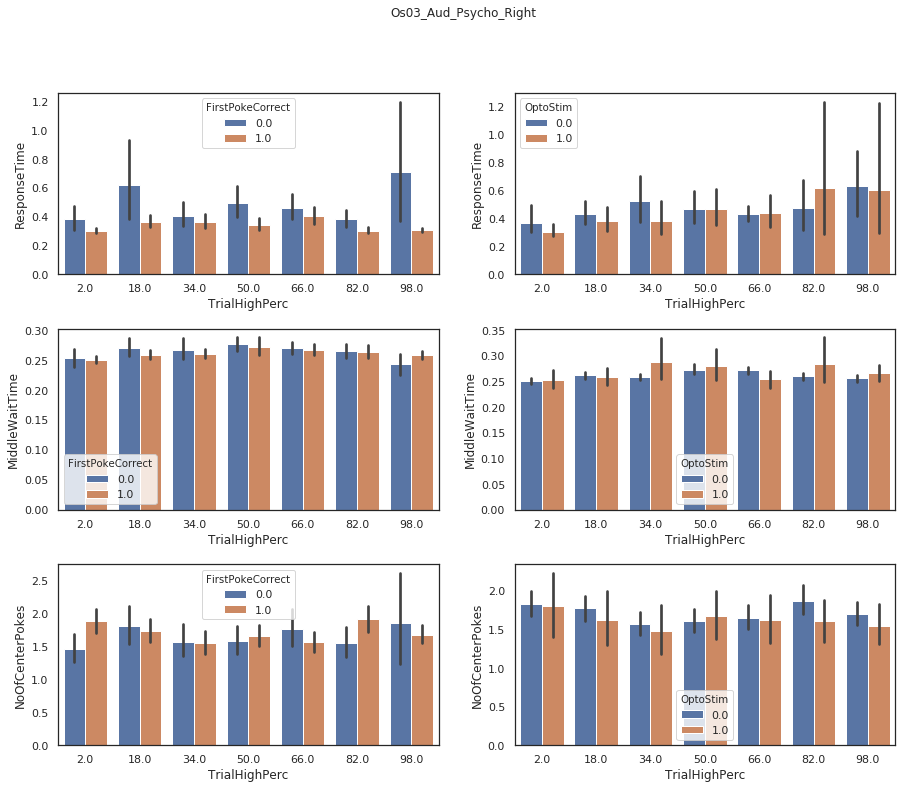

In [160]:
# Response time based on the difficulty and on whether the mouse is correct or not / optostimulation
# Number of pokes in the center

pulledData['NoOfCenterPokes'] = pulledData[['TrialEvents', 'TrialStates']].apply(custom_functions.CalculateMidPokes, axis=1)
pulledData['MiddleWaitTime'] = pulledData[['TrialEvents', 'TrialStates']].apply(custom_functions.MidPortWait, axis=1)

fig, ax = plt.subplots(3,2,figsize=(15,12))
ax = ax.ravel()
fig.subplots_adjust(hspace = 0.3)
sns.barplot(x='TrialHighPerc', y='ResponseTime', hue='FirstPokeCorrect', data=pulledData, ax=ax[0])
sns.barplot(x='TrialHighPerc', y='ResponseTime', hue='OptoStim', data=pulledData, ax=ax[1])
sns.barplot(x='TrialHighPerc', y='MiddleWaitTime', hue='FirstPokeCorrect', data=pulledData, ax=ax[2])
sns.barplot(x='TrialHighPerc', y='MiddleWaitTime', hue='OptoStim', data=pulledData, ax=ax[3])
sns.barplot(x='TrialHighPerc', y='NoOfCenterPokes', hue='FirstPokeCorrect', data=pulledData, ax=ax[4])
sns.barplot(x='TrialHighPerc', y='NoOfCenterPokes', hue='OptoStim', data=pulledData, ax=ax[5])
plt.suptitle(AnimalID + '_' + protToGroup + '_' + stimToGroup)
plt.show(fig)

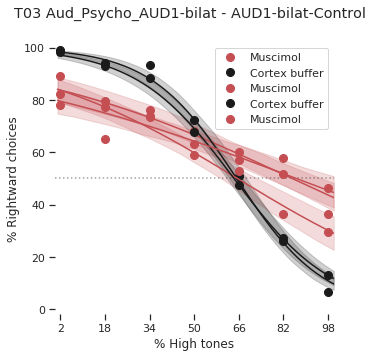

In [220]:
# plot an animated graph

# plot

# generate a list of the conditions, colors and labels
ColorList = ['r','k','r','k','r']
LabelList = ['Muscimol', 'Cortex buffer', 'Muscimol', 'Cortex buffer', 'Muscimol']

# plot
fig, ax = plt.subplots(figsize=(5, 5), facecolor='w', edgecolor='k')
ax.hlines(50, 0, 100, linestyles='dotted' , alpha=0.4)
for i,sessionID in enumerate(pd.unique(pulledData['SessionTime'])):
    predictDif, PsyPer, fakePredictions, predictPer, _ = \
    custom_functions.PP_ProcessExperiment(pulledData[pulledData['SessionTime']==sessionID], 100)
    if PsyPer:
        plot_utils.PlotPsychPerformance(dataDif = PsyPer['Difficulty'], dataPerf = PsyPer['Performance'],
                     predictDif = predictDif, ax = ax, fakePred = fakePredictions,
                     realPred = predictPer, color = ColorList[i], label = LabelList[i])
lgd = plt.legend()
plt.suptitle(AnimalID + ' ' + PlotsTitle)

plt.savefig(outputDir + AnimalID + '_' + PlotsTitle + '_psychometricPerformance_Muscimol.pdf',
            transparent=True, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show(fig)

In [221]:
pd.unique(pulledData['SessionTime'])

array(['May26 18:11', 'May27 18:37', 'May28 14:35', 'May29 16:15',
       'May30 14:42'], dtype=object)

In [ ]:
# SEND MAXIME THE DATA FOR THE PURPLE!
SD = pulledData[(pulledData['OptoStim']==1) & (pulledData['SwitchSide']==0)]

In [ ]:
diffs = np.array(SD['TrialHighPerc'])
choices = np.array(SD['FirstPoke'])

In [ ]:
nan_mask = ~(np.isnan(diffs) | np.isnan(choices))

In [ ]:
dset = pd.DataFrame({'Difficulty': diffs[nan_mask],
                      'Choice': choices[nan_mask]})

In [ ]:
X = np.array(dset.Difficulty)
y_data = dset.groupby('Difficulty').agg(lambda x: np.mean(x == 2))
y = np.array(dset.Choice == 2)

# fit the model parameters and print optimization results
params, res = Lapse_model.fit_lapse_model(X, y)
print(res)

# display results
plt.figure()
plt.plot(y_data, 'o')
xs = np.linspace(min(X) - 0.5, max(X) + 0.5)
plt.plot(xs, Lapse_model.predict_lapse_model(xs, *params))
plt.show()


In [ ]:
res




Go step by step: DEPRECATED. Go through and fix

In [ ]:
# select a session
x = 13

In [ ]:
# Split data into normal and opto trials
ExpNor, ExpOp = custom_functions.splitOpto(ExperimentData[x]['SessionData'])

In [ ]:
# Calculate psychometric performance parameters for each
Normal_PsyPer = custom_functions.PsychPerformance(trialsDif = ExpNor['Difficulty'], sideSelected = ExpNor['SideSelected'])
Opto_PsyPer = custom_functions.PsychPerformance(trialsDif = ExpOp['Difficulty'], sideSelected = ExpOp['SideSelected'])

In [ ]:
# predict data
predictDif = np.linspace(1, 100, 2000).reshape(-1, 1)

if Normal_PsyPer:
    Normal_predictPer = 100 * Normal_PsyPer['Logit'].predict_proba(predictDif)[:,1]
if Opto_PsyPer:
    Opto_predictPer = 100 * Opto_PsyPer['Logit'].predict_proba(predictDif)[:,1]

In [ ]:
# Bootstrap on fake data (generated inside the bootstrap function)
bootstrap_ntimes = 1000
np.random.seed(12233)  # fixed random seed for reproducibility

if Normal_PsyPer:
    Normal_fakePredictions = custom_functions.BootstrapPerformances(trialsDif = ExpNor['Difficulty'],
                                                                    sideSelected = ExpNor['SideSelected'],
                                                                    ntimes = bootstrap_ntimes,
                                                                    prediction_difficulties = predictDif)
if Opto_PsyPer:
    Opto_fakePredictions = custom_functions.BootstrapPerformances(trialsDif = ExpOp['Difficulty'],
                                                                    sideSelected = ExpOp['SideSelected'],
                                                                    ntimes = bootstrap_ntimes,
                                                                    prediction_difficulties = predictDif)

In [ ]:
fig, axs = plt.subplots(1,1,figsize=(5, 5), facecolor='w', edgecolor='k')

if Normal_PsyPer:
    plot_utils.PlotPsychPerformance(dataDif = Normal_PsyPer['Difficulty'], dataPerf = Normal_PsyPer['Performance'],
                     predictDif = predictDif, ax = axs, fakePred = Normal_fakePredictions,
                     realPred = Normal_predictPer, color = 'c', label = 'normal')

if Opto_PsyPer:
    plot_utils.PlotPsychPerformance(dataDif = Opto_PsyPer['Difficulty'], dataPerf = Opto_PsyPer['Performance'],
                         predictDif = predictDif, ax = axs, fakePred = Opto_fakePredictions,
                         realPred = Opto_predictPer, color = 'm', label = 'opto')
lgd = plt.legend()
plt.title(AnimalID + ' ' + str(x) + ': ' + ExperimentTimes[x])

plt.savefig(outputDir + AnimalID + '_' + ExperimentTimes[x] + '_psychometricPerformance.pdf', transparent=True,
            bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.show(fig)